Files already downloaded and verified
Files already downloaded and verified
[1,   100] loss: 4.605
[1,   200] loss: 4.603
[1,   300] loss: 4.600
[2,   100] loss: 4.595
[2,   200] loss: 4.591
[2,   300] loss: 4.584
[3,   100] loss: 4.561
[3,   200] loss: 4.543
[3,   300] loss: 4.511
[4,   100] loss: 4.390
[4,   200] loss: 4.299
[4,   300] loss: 4.244
[5,   100] loss: 4.135
[5,   200] loss: 4.086
[5,   300] loss: 4.034
Accuracy with (8, 16) channels: 10.23
[1,   100] loss: 4.606
[1,   200] loss: 4.601
[1,   300] loss: 4.596
[2,   100] loss: 4.584
[2,   200] loss: 4.572
[2,   300] loss: 4.548
[3,   100] loss: 4.467
[3,   200] loss: 4.391
[3,   300] loss: 4.315
[4,   100] loss: 4.125
[4,   200] loss: 4.025
[4,   300] loss: 3.980
[5,   100] loss: 3.852
[5,   200] loss: 3.804
[5,   300] loss: 3.789
Accuracy with (16, 32) channels: 14.11
[1,   100] loss: 4.603
[1,   200] loss: 4.599
[1,   300] loss: 4.595
[2,   100] loss: 4.578
[2,   200] loss: 4.563
[2,   300] loss: 4.536
[3,   100] loss: 4.

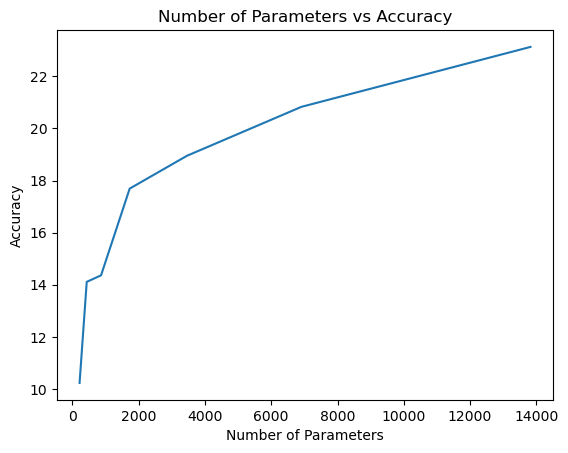

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
import matplotlib.pyplot as plt

class Net(nn.Module):
    def __init__(self, num_channels=(32, 64), num_classes=100):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, num_channels[0], 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(num_channels[0], num_channels[1], 3, padding=1)
        self.fc1 = nn.Linear(num_channels[1] * 8 * 8, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

def train_model(model, criterion, optimizer, trainloader, num_epochs=5):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0

def evaluate_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

num_channels_list = [(8, 16), (16, 32), (32, 64), (64, 128), (128, 256), (256, 512), (512, 1024)]

accuracies = []
for num_channels in num_channels_list:
    model = Net(num_channels=num_channels)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    train_model(model, criterion, optimizer, trainloader, num_epochs=5)
    accuracy = evaluate_model(model, testloader)
    accuracies.append(accuracy)
    print(f'Accuracy with {num_channels} channels: {accuracy}')

plt.plot([sum(c) * 3 * 3 for c in num_channels_list], accuracies)
plt.xlabel('Number of Parameters')
plt.ylabel('Accuracy')
plt.title('Number of Parameters vs Accuracy')
plt.show()
